# Viscous stress tensor calculation with wall slip

The viscous stress tensor for a Newtonian fluid is usually expressed as a linear function of
the velocity gradient, i.e.,
$\tau_{ij} = \eta(u_{i,j} + u_{j,i}) + (\zeta - \frac{2}{3}\eta)u_{i,i}\delta_{ij}$.
Here, we seek an expression in terms of the gap-averaged densities of conserved
variables $\rho(x, y)$, $j_x(x, y)$, and $j_y(x, y)$.
We use [Sympy](https://sympy.org) to derive the expressions for the stress tensor components.

We start with a common ansatz for the velocity profiles

$u(z) = a z (h - z) + \frac{U_\rm{top} - U_\rm{bot}}{h} z + U_\rm{bot}$,

$v(z) = b z (h - z) + \frac{V_\rm{top} - V_\rm{bot}}{h} z + V_\rm{bot}$,

$w(z) = cz^2(h - z)^2$,

for $z \in [0, h]$.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import sympy as sp

import GaPFlow.viz

# Define Cartesian coordinates
x, y, z = sp.symbols("x y z")

# Define some constants
zeta, eta = sp.symbols("zeta eta")  # Viscosities

# The unknown parameters for the nonlinear part, that we need to find
a, b, c = sp.symbols("a b c")

# The gap height is a function of the lateral coordinates
h = sp.Function("h")

$U_\rm{bot}$, $U_\rm{top}$, $V_\rm{bot}$, $V_\rm{top}$ are the velocity of the outermost fluid
layers in contact with the the bottom and top wall, and in $x$ and $y$ direction, respectively.
In the case of the no slip boundary condition, these velocities are identical
with those of the wall. For the no slip boundary conditions, we have to account for the slip length $L_\rm{slip}$

$U_\rm{bot} = U_\rm{bot,wall} + L_\rm{slip, bot}\left(\frac{\partial u}{\partial z}\right)_{z=0}$,

$U_\rm{top} = U_\rm{top,wall} - L_\rm{slip, top}\left(\frac{\partial u}{\partial z}\right)_{z=h}$,

$V_\rm{bot} = V_\rm{bot,wall} + L_\rm{slip, top}\left(\frac{\partial v}{\partial z}\right)_{z=0}$,

$V_\rm{top} = V_\rm{top,wall} - L_\rm{slip, top}\left(\frac{\partial v}{\partial z}\right)_{z=h}$.

In [2]:
# Define symbols
Lsb, Lst = sp.symbols("Lsb Lst")
Utw, Ubw, Vtw, Vbw = sp.symbols("Utw Ubw Vtw Vbw")
Ut, Ub, Vt, Vb = sp.symbols("Ut Ub Vt Vb")

In [3]:
# Velocity profiles
_u = (Ut - Ub) * z / h(x, y) + Ub + a * z * (h(x, y) - z)
_v = (Vt - Vb) * z / h(x, y) + Vb + b * z * (h(x, y) - z)
w = c * z**2 * (h(x, y) - z) ** 2

# Helper variables
__Ub = Ubw + Lsb * sp.diff(_u, z).subs(z, 0)
__Ut = Utw - Lst * sp.diff(_u, z).subs(z, h(x, y))
__Vb = Vbw + Lsb * sp.diff(_v, z).subs(z, 0)
__Vt = Vtw - Lst * sp.diff(_v, z).subs(z, h(x, y))

# Replace boundary layer velcoities
u = _u.subs({Ub: __Ub, Ut: __Ut})
v = _v.subs({Vb: __Vb, Vt: __Vt})

The unknown parameters can be found by using the definition of the
gap-averaged fluxes, e.g.

$j_x(x, y) = \frac{\rho(x, y)}{h(x,y)}\int_0^{h(x, y)} u(z) dz$,

where we assume that the density is constant across the gap.

In [4]:
# Define continuum fields as functions
jx = sp.Function("jx")
jy = sp.Function("jy")
jz = sp.Function("jz")
rho = sp.Function("rho")

# Define equations
eq1 = sp.Eq(jx(x, y), rho(x, y) / h(x, y) * sp.integrate(u, (z, 0, h(x, y))))
eq2 = sp.Eq(jy(x, y), rho(x, y) / h(x, y) * sp.integrate(v, (z, 0, h(x, y))))
eq3 = sp.Eq(jz(x, y), rho(x, y) / h(x, y) * sp.integrate(w, (z, 0, h(x, y))))

# Solve for a, b, c
(_a,) = sp.solveset(eq1, a)
(_b,) = sp.solveset(eq2, b)
(_c,) = sp.solveset(eq3, c)

Furthermore, we solve for the boundary layer velocities using

$U_{bot} = u(0)$, $U_{top} = u(h)$,

$V_{bot} = v(0)$, $V_{top} = v(h)$.

In [5]:
eq4 = sp.Eq(Ub, u.subs(a, _a).subs(z, 0))
(_Ub,) = sp.solveset(eq4, Ub)

eq5 = sp.Eq(Ut, u.subs(a, _a).subs(z, h(x, y)).subs(Ub, _Ub))
(_Ut,) = sp.solveset(eq5, Ut)

eq6 = sp.Eq(Vb, v.subs(b, _b).subs(z, 0))
(_Vb,) = sp.solveset(eq6, Vb)

eq7 = sp.Eq(Vt, v.subs(b, _b).subs(z, h(x, y)).subs(Vb, _Vb))
(_Vt,) = sp.solveset(eq7, Vt)

It is important to realize that the solutions depend on the lateral coordinates.
Thus, before we differentiate, we need to substitute the solutions
into the expressions for the velocity profiles using ```subs```.

In [6]:
u_final = u.subs(a, _a).subs(Ub, _Ub).subs(Ut, _Ut)
v_final = v.subs(b, _b).subs(Vb, _Vb).subs(Vt, _Vt)

# Compute velocity gradients
du_dx = sp.diff(u_final, x)
du_dy = sp.diff(u_final, y)
du_dz = sp.diff(u_final, z)

dv_dx = sp.diff(v_final, x)
dv_dy = sp.diff(v_final, y)
dv_dz = sp.diff(v_final, z)

dw_dx = sp.diff(w.subs(c, _c), x)
dw_dy = sp.diff(w.subs(c, _c), y)
dw_dz = sp.diff(w.subs(c, _c), z)

# Symmetrize
Dxx = du_dx
Dyy = dv_dy
Dzz = dw_dz
Dxy = (du_dy + dv_dx) / 2
Dxz = (du_dz + dw_dx) / 2
Dyz = (dv_dz + dw_dy) / 2

# Trace
trD = Dxx + Dyy + Dzz

v1, v2 = sp.symbols("v1 v2")
# v1 = (zeta + sp.Rational(4, 3) * eta)
# v2 = (zeta - sp.Rational(2, 3) * eta)

# Viscous stress
Txx = v1 * Dxx + v2 * (Dyy + Dzz)
Tyy = v1 * Dyy + v2 * (Dxx + Dzz)
Tzz = v1 * Dzz + v2 * (Dxx + Dyy)
Txy = 2 * eta * Dxy
Txz = 2 * eta * Dxz
Tyz = 2 * eta * Dyz

The above expressions have been used to generate Python code used in `GaPFlow`. Thus, we make some useful syntactic replacements: 

In [7]:
H, Hx, Hy = sp.symbols("h[0] h[1] h[2]")
q0, q1, q2 = sp.symbols("q[0] q[1] q[2]")
dq0x, dq1x, dq2x = sp.symbols("dqx[0] dqx[1] dqx[2]")
dq0y, dq1y, dq2y = sp.symbols("dqy[0] dqy[1] dqy[2]")
U, V, Ls = sp.symbols("U V Ls")


_replace = {
    sp.Derivative(h(x, y), x): Hx,
    sp.Derivative(h(x, y), y): Hy,
    h(x, y): H,
    rho(x, y): q0,
    jx(x, y): q1,
    jy(x, y): q2,
    jz(x, y): 0,
    sp.Derivative(rho(x, y), x): dq0x,
    sp.Derivative(rho(x, y), y): dq0y,
    sp.Derivative(jx(x, y), x): dq1x,
    sp.Derivative(jx(x, y), y): dq1y,
    sp.Derivative(jy(x, y), x): dq2x,
    sp.Derivative(jy(x, y), y): dq2y,
    sp.Derivative(jz(x, y), x): 0,
    sp.Derivative(jz(x, y), y): 0,
    Ubw: U,
    Vbw: V,
    Vtw: 0,
    Utw: 0,
}

We may want to consider different combinations of slip/no-slip boundary conditions at the top and bottom walls:

In [8]:
# No slip
replace_no_slip = deepcopy(_replace)
replace_no_slip["Lsb"] = 0
replace_no_slip["Lst"] = 0

# Bottom: slip BC, top: no slip
replace_slip_bottom = deepcopy(_replace)
replace_slip_bottom["Lsb"] = Ls
replace_slip_bottom["Lst"] = 0

# Bottom: no slip, top: slip BC
replace_slip_top = deepcopy(_replace)
replace_slip_top["Lsb"] = 0
replace_slip_top["Lst"] = Ls

# Bottom: slip BC, top: slip BC (same slip length on both walls)
replace_slip_both = deepcopy(_replace)
replace_slip_both["Lsb"] = Ls
replace_slip_both["Lst"] = Ls

The following functions can be used to generate the Python code:

In [9]:
def write_velocity_profiles(replacement):
    print("u = ", sp.simplify(u_final.subs(replacement)))
    print("v = ", sp.simplify(v_final.subs(replacement)))

def write_stress_profiles(replacement):
    print("tau_xx = ", sp.simplify(Txx.subs(replacement)))
    print("tau_yy = ", sp.simplify(Tyy.subs(replacement)))
    print("tau_zz = ", sp.simplify(Tzz.subs(replacement)))
    print("tau_xy = ", sp.simplify(Txy.subs(replacement)))
    print("tau_xz = ", sp.simplify(Txz.subs(replacement)))
    print("tau_yz = ", sp.simplify(Tyz.subs(replacement)))

def write_stress_bottom(replacement):
    print("tau_xx(z=0) = ", sp.simplify(Txx.subs(replacement).subs(z, 0)))
    print("tau_yy(z=0) = ", sp.simplify(Tyy.subs(replacement).subs(z, 0)))
    print("tau_zz(z=0) = ", sp.simplify(Tzz.subs(replacement).subs(z, 0)))
    print("tau_xy(z=0) = ", sp.simplify(Txy.subs(replacement).subs(z, 0)))
    print("tau_xz(z=0) = ", sp.simplify(Txz.subs(replacement).subs(z, 0)))
    print("tau_yz(z=0) = ", sp.simplify(Tyz.subs(replacement).subs(z, 0)))

def write_stress_top(replacement, H):
    print("tau_xx(z=h) = ", sp.simplify(Txx.subs(replacement).subs(z, H)))
    print("tau_yy(z=h) = ", sp.simplify(Tyy.subs(replacement).subs(z, H)))
    print("tau_zz(z=h) = ", sp.simplify(Tzz.subs(replacement).subs(z, H)))
    print("tau_xy(z=h) = ", sp.simplify(Txy.subs(replacement).subs(z, H)))
    print("tau_xz(z=h) = ", sp.simplify(Txz.subs(replacement).subs(z, H)))
    print("tau_yz(z=h) = ", sp.simplify(Tyz.subs(replacement).subs(z, H)))

def write_stress_avg(replacement):
    # Average stress
    Txx_avg = sp.integrate(
        sp.simplify(Txx.subs(replacement)), (z, 0, h(x, y))
    ) / h(x, y)

    print("tau[0] = ", sp.simplify(Txx_avg.subs(h(x, y), H)))
        
    Tyy_avg = sp.integrate(
        sp.simplify(Tyy.subs(replacement)), (z, 0, h(x, y))
    ) / h(x, y)

    print("tau[1] = ", sp.simplify(Tyy_avg.subs(h(x, y), H)))
    
    Txy_avg = sp.integrate(
        sp.simplify(Txy.subs(replacement)), (z, 0, h(x, y))
    ) / h(x, y)
    
    print("tau[2] = ", sp.simplify(Txy_avg.subs(h(x, y), H)))

For instance, the Python code for the gap-averaged wall stress components $\bar{\tau}_{xx}$, $\bar{\tau}_{yy}$, and $\bar{\tau}_{xy}$ with slip BC at the top wall can be generated like this:

In [10]:
write_stress_avg(replace_slip_top)

tau[0] =  (2*Ls*U*h[1]*q[0]**2*v1 + 2*Ls*V*h[2]*q[0]**2*v2 - 4*Ls*dqx[0]*h[0]*q[1]*v1 + 4*Ls*dqx[1]*h[0]*q[0]*v1 - 4*Ls*dqy[0]*h[0]*q[2]*v2 + 4*Ls*dqy[2]*h[0]*q[0]*v2 - 2*Ls*h[1]*q[0]*q[1]*v1 - 2*Ls*h[2]*q[0]*q[2]*v2 - dqx[0]*h[0]**2*q[1]*v1 + dqx[1]*h[0]**2*q[0]*v1 - dqy[0]*h[0]**2*q[2]*v2 + dqy[2]*h[0]**2*q[0]*v2 + h[0]*h[1]*q[0]*q[1]*v1 + h[0]*h[2]*q[0]*q[2]*v2)/(h[0]*q[0]**2*(4*Ls + h[0]))
tau[1] =  (2*Ls*U*h[1]*q[0]**2*v2 + 2*Ls*V*h[2]*q[0]**2*v1 - 4*Ls*dqx[0]*h[0]*q[1]*v2 + 4*Ls*dqx[1]*h[0]*q[0]*v2 - 4*Ls*dqy[0]*h[0]*q[2]*v1 + 4*Ls*dqy[2]*h[0]*q[0]*v1 - 2*Ls*h[1]*q[0]*q[1]*v2 - 2*Ls*h[2]*q[0]*q[2]*v1 - dqx[0]*h[0]**2*q[1]*v2 + dqx[1]*h[0]**2*q[0]*v2 - dqy[0]*h[0]**2*q[2]*v1 + dqy[2]*h[0]**2*q[0]*v1 + h[0]*h[1]*q[0]*q[1]*v2 + h[0]*h[2]*q[0]*q[2]*v1)/(h[0]*q[0]**2*(4*Ls + h[0]))
tau[2] =  eta*(2*Ls*U*h[2]*q[0]**2 + 2*Ls*V*h[1]*q[0]**2 - 4*Ls*dqx[0]*h[0]*q[2] + 4*Ls*dqx[2]*h[0]*q[0] - 4*Ls*dqy[0]*h[0]*q[1] + 4*Ls*dqy[1]*h[0]*q[0] - 2*Ls*h[1]*q[0]*q[2] - 2*Ls*h[2]*q[0]*q[1] - dqx[0]*

Here, we directly import these expression from {py:mod}`GaPFlow.models.profiles` to use them for visualization.

In [11]:
from GaPFlow.models.profiles import get_velocity_profiles, get_stress_profiles 
from GaPFlow.models.viscous import stress_top, stress_bottom

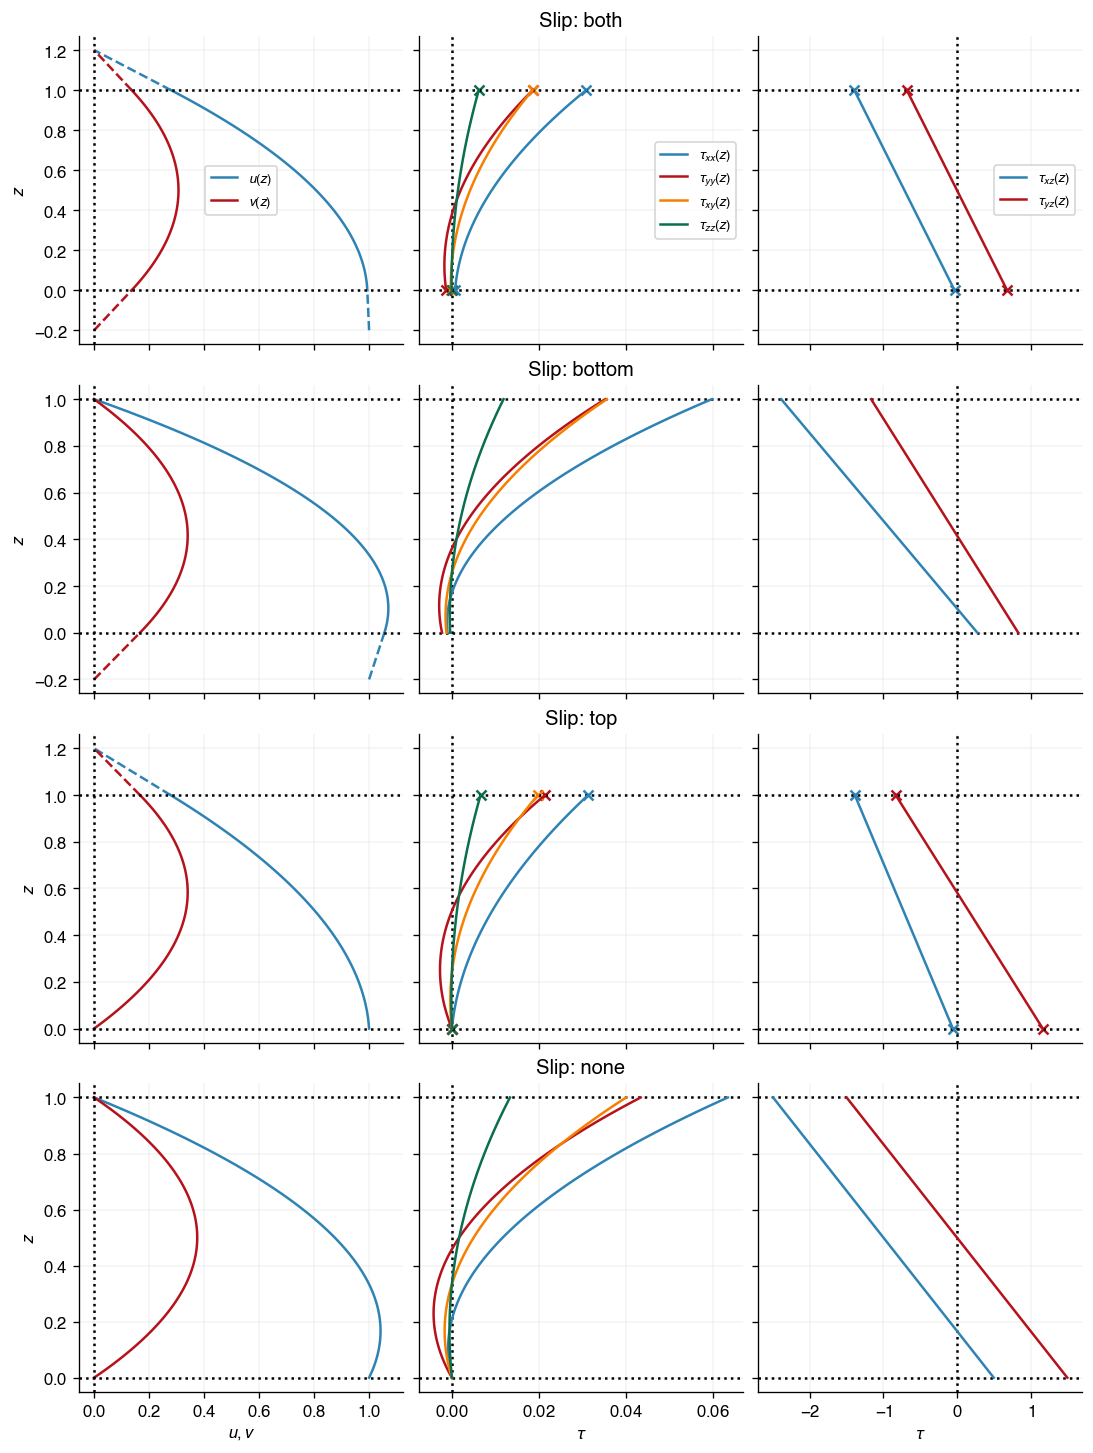

In [12]:
q_test = np.array([1.0, 0.75, 0.25])
h_test = np.array([1.0, 0.01, 0.01])  # "small slopes"

dqx_test = np.array([0., 0., 0.]) # Similarly, we assume gradients to the solution field are small.
dqy_test = np.array([0., 0., 0.]) # Since they do not affect the dominant wall stress components (τ_xz, τ_yz), we ignore them entirely.

z_test = np.linspace(0.0, h_test[0], 100)

Ls = 0.2
U = 1.0
V = 0.0

fig, axes = plt.subplots(4, 3, sharey="row", sharex="col", figsize=(9, 12))

for i, mode in enumerate(["both", "bottom", "top", "none"]):

    ax = axes[i]

    u_test, v_test = get_velocity_profiles(
        z_test, q_test, Ls=Ls, U=U, V=V, slip=mode
    )
    tau_xx, tau_yy, tau_zz, tau_yz, tau_xz, tau_xy = get_stress_profiles(
        z_test, h_test, q_test, dqx_test, dqy_test, Ls=Ls, mode=mode
    )

    ax[0].plot(u_test, z_test, label=r"$u(z)$")
    ax[0].plot(v_test, z_test, label=r"$v(z)$")

    if mode in ["both", "top"]:
        ax[0].plot(
            [u_test[-1], 0], [h_test[0], h_test[0] + Ls], "--", color="C0"
        )
        ax[0].plot(
            [v_test[-1], 0], [h_test[0], h_test[0] + Ls], "--", color="C1"
        )
    if mode in ["both", "bottom"]:
        ax[0].plot([U, u_test[0]], [-Ls, 0], "--", color="C0")
        ax[0].plot([V, v_test[0]], [-Ls, 0], "--", color="C1")

    for a in ax:
        a.axhline(0.0, ls=":", color="0.0")
        a.axhline(h_test[0], ls=":", color="0.0")
        a.axvline(0.0, ls=":", color="0.0")

    ax[0].set_ylabel(r"$z$")

    ax[1].plot(tau_xx, z_test, label=r"$\tau_{xx}(z)$")
    ax[1].plot(tau_yy, z_test, label=r"$\tau_{yy}(z)$")
    ax[1].plot(tau_xy, z_test, label=r"$\tau_{xy}(z)$") 
    ax[1].plot(tau_zz, z_test, label=r"$\tau_{zz}(z)$")
    
    ax[2].plot(tau_xz, z_test, label=r"$\tau_{xz}(z)$")
    ax[2].plot(tau_yz, z_test, label=r"$\tau_{yz}(z)$")
    
    # plot wall stress
    if mode in ['top', 'both']:
        tau_top = stress_top(q_test, h_test, U=1., V=0., eta=1., zeta=1., Ls=Ls, slip=mode)
        tau_bot = stress_bottom(q_test, h_test, U=1., V=0., eta=1., zeta=1., Ls=Ls, slip=mode)
        
        ax[1].scatter([tau_bot[0], tau_top[0]], [z_test[0], z_test[-1]], color='C0')
        ax[1].scatter([tau_bot[1], tau_top[1]], [z_test[0], z_test[-1]], color='C1')
        ax[1].scatter([tau_bot[5], tau_top[5]], [z_test[0], z_test[-1]], color='C2')
        ax[1].scatter([tau_bot[2], tau_top[2]], [z_test[0], z_test[-1]], color='C3')
        
        ax[2].scatter([tau_bot[4], tau_top[4]], [z_test[0], z_test[-1]], color='C0')
        ax[2].scatter([tau_bot[3], tau_top[3]], [z_test[0], z_test[-1]], color='C1')

    if i == 0:
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()

    ax[1].set_title(f"Slip: {mode}")

ax[0].set_xlabel(r"$u, v$")
ax[1].set_xlabel(r"$\tau$")
ax[2].set_xlabel(r"$\tau$")

plt.show()

Note the different scales for the shear stress in the center and the right column.

See also: [Holey, H. et al. (2022) Tribology Letters, 70(2), p. 36.](https://doi.org/10.1007/s11249-022-01576-5)